(4905.82875149675, 4377.0, 1863.3382276699708)


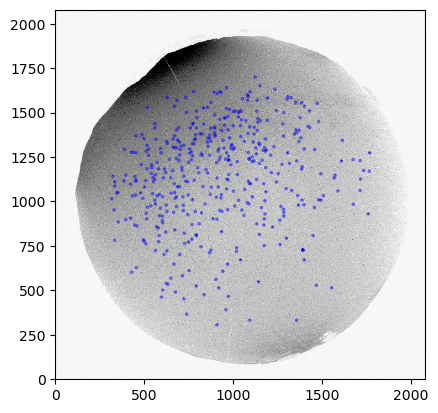

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
from photutils.detection import DAOStarFinder

from cloud_to_data import Mask

mask = Mask()
mask_data = mask.data
t = mask_data == 0
mask_data = t

# 读取图像
datafits = fits.open("ossaf/data/2023_05_23__00_24_04.fits.bz2")[0]
data = datafits.data[0]
gain = datafits.header['GAIN_ELE']
# data = data / 1e6


mean, median, std = sigma_clipped_stats(data, mask=mask_data, sigma=3.0)
print((mean, median, std))

# 创建DAOStarFinder对象
daofind = DAOStarFinder(fwhm=4.0, threshold=5. * std)

# 提取点源
sources = daofind.find_stars(data - median, mask=mask_data)

# 打印点源坐标和其他属性
# print(sources)

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)



(4053.812426453283, 3530.0, 2111.294826161956)
 id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
  1  709.9248976207011 ... 1.4953304563573382  -0.43684294739266805
  2   1373.25923644867 ... 1.8750859398383761   -0.6825529432823602
  3  978.2008293078113 ... 1.1678059304519222   -0.1684266909805956
  4 1067.2580615984232 ...  2.293068479619218   -0.9010425614614216
  5 1466.1657766837984 ... 1.2277822832566816   -0.2228034056873905
  6 1332.0156006982259 ... 1.0192469634014827 -0.020698565628258003
  7 1233.9209944117908 ... 2.3916973304311955   -0.9467655469441698


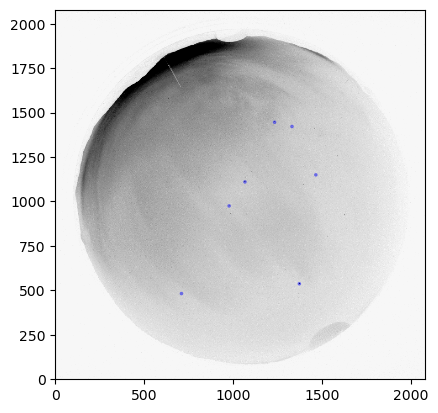

In [17]:
datafits = fits.open("ossaf/data/2023_05_27__01_19_08.fits.bz2")[0]
# 读取图像
data = datafits.data[0]
gain = datafits.header['GAIN_ELE']
# data = data / 1e6


mean, median, std = sigma_clipped_stats(data, mask=mask_data, sigma=3.0)
print((mean, median, std))

# 创建DAOStarFinder对象
daofind = DAOStarFinder(fwhm=4.0, threshold=5. * std)

# 提取点源
sources = daofind.find_stars(data - median, mask=mask_data)

# 打印点源坐标和其他属性
print(sources)

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)



In [18]:
# 像素坐标系到地平坐标系的映射
from astropy import units as u
from astropy.coordinates import SkyCoord, AltAz, EarthLocation
from astropy.time import Time


mask.center.x

mask.center.y

sources

In [19]:
def to_altaz(x, y, x_offset=1053, y_offset=1017, radius=983, north=155.6 * u.deg):
    # move to center
    x = x - 1053
    y = y - 1017

    # polar coordinates
    r = np.sqrt(x ** 2 + y ** 2)
    theta = np.arctan2(y, x)
    print(f"theta: {theta}, r: {r}")

    # convert to altaz
    alt = r / radius * u.rad * np.pi / 2
    alt = np.pi / 2 * u.rad - alt
    az = (- theta) * u.rad - north
    print(f"alt: {alt}, az: {az}")

    return AltAz(alt=alt, az=az)

to_altaz(1100, 1017)

star = to_altaz(sources[1]['xcentroid'], sources[1]['ycentroid'])
star

In [20]:
location = EarthLocation(lat=43.82416667 * u.deg, lon=126.331111 * u.deg, height=313 * u.m)

time = datafits.header['DATE-OBS']
time = Time(time, format='isot', scale='utc', location=location)
time = time - 8 * u.hour

frame = AltAz(obstime=time, location=location)


In [21]:
import sqlite3

engine = sqlite3.connect('ossaf/data/tyc2.sqlite')


In [22]:
import pandas as pd

tyc2 = pd.read_sql_query("SELECT * FROM tyc2 WHERE VTmag < 8 ", engine)

(90 * u.deg / 983).to(u.arcmin)

(360 * u.deg / (2 * np.pi * 983)).to(u.arcmin)

In [23]:
def find_tyc_star(star: SkyCoord, altaz):
    d_ra = tyc2.RA_ICRS_ - star.ra
    d_dec = tyc2.DE_ICRS_ - star.dec

    d = d_ra ** 2 + d_dec ** 2

    min_id = np.argmin(d)
    min_d = np.sqrt(d[min_id])

    print(f"min_d: {min_d}, min_id: {min_id}")

    threshold = min_d_threshold(altaz)

    if min_d > threshold:
        return None, min_d
    else:
        return tyc2.iloc[min_id], min_d


def min_d_threshold(star: AltAz, factor=20):
    a = 2 * star.alt.to(u.rad).value / np.pi
    print(a)
    b = (1 - a) * mask.full_radius
    print(b)
    c = (1 / b)
    print(c)
    c *= factor
    result = c * 360 / 2 / np.pi
    return result

find_tyc_star(tstar, star)

((1 / ((1 - 2 * 0.64 / np.pi) * 983)) * u.rad).to(u.arcmin)


((1 / ((1 - 2 * 0.64 / np.pi) * 983)) * u.rad).to(u.deg)


(1 / ((1 - 2 * 0.64 / np.pi) * 983)) * 360 / (2 * np.pi)

In [24]:
type(sources)

astropy.table.table.QTable

In [25]:
df_source = sources.to_pandas()
altaz_sources = to_altaz(df_source.xcentroid.to_numpy(), df_source.ycentroid.to_numpy())
star = SkyCoord(alt=altaz_sources.alt, az=altaz_sources.az, frame=frame)
icrs_sources = star.transform_to('icrs')

valid_sources = pd.DataFrame()
num_valid_sources = 0
for i in range(len(icrs_sources)):
    tyc, r = find_tyc_star(icrs_sources[i], star[i])
    print(tyc, r)
    if tyc is not None:
        num_valid_sources += 1
        valid_sources = pd.concat([valid_sources, tyc], axis=1)
valid_sources = valid_sources.T

theta: [-2.14097412 -0.98237849 -2.63213072  1.41895958  0.31130392  0.96759097
  1.17170753], r: [635.58117271 576.99621937  85.67991585  94.26568252 434.02730431
 491.84372741 465.5965396 ]
alt: [0.55516197 0.64877848 1.4338831  1.42016338 0.87723733 0.7848489
 0.8267909 ] rad, az: [-0.57475819 -1.73335382 -0.0836016  -4.1346919  -3.02703624 -3.68332328
 -3.88743985] rad
min_d: 0.1611297969070604, min_id: 18298
0.35342708778250087
635.5811727098016
0.001573363156332177
_RAJ2000     165.841061
_DEJ2000      61.654265
recno           1086407
TYC1               4146
TYC2                354
TYC3                  1
pmRA        -117.400002
pmDE         -65.599998
BTmag             7.744
VTmag             7.194
HIP         -2147483648
RA_ICRS_     165.841633
DE_ICRS_      61.654416
ID           4146-354-1
Name: 18298, dtype: object 0.1611297969070604
min_d: 0.5923997375940879, min_id: 41916
0.4130252091824492
576.9962193736524
0.0017331136087607847
_RAJ2000     213.915278
_DEJ2000      19.1

In [26]:
num_valid_sources

7

In [27]:
len(icrs_sources)

7

# 填充天区

每10°为一个跨度填充天区

In [28]:
valid_sources

,_RAJ2000,_DEJ2000,recno,TYC1,TYC2,TYC3,pmRA,pmDE,BTmag,VTmag,HIP,RA_ICRS_,DE_ICRS_,ID
18298,165.841061,61.654265,1086407,4146,354,1,-117.400002,-65.599998,7.744,7.194,-2147483648,165.841633,61.654416,4146-354-1
41916,213.915278,19.182346,2256,1472,1436,2,-1093.400024,-1999.400024,NaN,3.487,69673,213.918092,19.187205,1472-1436-2
15301,269.151572,51.488949,883559,3523,1684,1,NaN,NaN,4.246,2.381,87833,269.151572,51.488949,3523-1684-1
13232,278.839733,38.894839,756190,3105,820,1,-6.9,-3.3,6.999,6.966,-2147483648,278.839753,38.894847,3105-820-1
1740,265.482705,4.3668,85614,423,230,1,14.2,-9.0,8.126,7.093,86611,265.482672,4.366821,423-230-1
1956,291.374577,3.114782,97623,469,6227,1,254.800003,82.099998,3.738,3.39,95501,291.373995,3.114595,469-6227-1
4339,297.289614,8.277327,226807,1058,2677,1,6.5,-2.2,8.025,7.709,97510,297.289599,8.277332,1058-2677-1


In [29]:
valid_icrs = SkyCoord(ra=valid_sources.RA_ICRS_ * u.deg, dec=valid_sources.DE_ICRS_ * u.deg, frame='icrs')
valid_altaz = valid_icrs.transform_to(frame)
valid_altaz

<SkyCoord (AltAz: obstime=2023-05-26T17:18:05.066, location=(-2730754.63291691, 3713244.39125283, 4394233.85212166) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    [(326.96551918, 31.83479929), (260.31584226, 37.64938535),
     (357.31422536, 82.33144649), (122.42540436, 81.55234667),
     (186.40857914, 50.36456331), (148.37923384, 44.99308337),
     (137.50256978, 47.08623095)]>

遍历天区，查看该天区是否有可见的星
天区以 10*10平方度 为一块区域

In [30]:
# 创建空白的表格
sky_zone = pd.DataFrame(columns=['alt', 'az', 'valid'])
for alt in range(0, 100, 10):
    for az in range(0, 370, 10):
        sky_zone = pd.concat([sky_zone, pd.DataFrame([[alt, az, 0]], columns=['alt', 'az', 'valid'])])

# 遍历可见星，填充表格
for vstar in valid_altaz:
    alt = vstar.alt.to(u.deg).value // 10 * 10
    az = vstar.az.to(u.deg).value // 10 * 10
    print(f"alt: {alt}, az: {az}")
    sky_zone.loc[(sky_zone.alt == alt) & (sky_zone.az == az), 'valid'] += 1

alt: 30.0, az: 320.0
alt: 30.0, az: 260.0
alt: 80.0, az: 350.0
alt: 80.0, az: 120.0
alt: 50.0, az: 180.0
alt: 40.0, az: 140.0
alt: 40.0, az: 130.0


In [31]:
sky_zone

,alt,az,valid
0,0,0,0
0,0,10,0
0,0,20,0
0,0,30,0
0,0,40,0
...,...,...,...
0,90,320,0
0,90,330,0
0,90,340,0
0,90,350,0


TODO: 用 healpix 表示